<a href="https://colab.research.google.com/github/rajendranast012-stack/in-silico-lab1/blob/main/tanimoto_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit
!pip install pandas
!pip install seaborn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 23.6 MB/s eta 0:00:00


In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from sklearn.cluster import KMeans

# --- Step 1: Load SMILES ---
df = pd.read_excel('/content/flavonoid_smile.xlsx')  # adjust path
smiles_list = df['SMILES'].tolist()       # Replace 'SMILES' with your column name

# --- Step 2: Generate MACCS fingerprints ---
fps = []
valid_indices = []
for i, smi in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        fp = MACCSkeys.GenMACCSKeys(mol)
        fps.append(fp)
        valid_indices.append(i)

n = len(fps)
print(f"Valid molecules: {n}")

Valid molecules: 204


In [3]:
# --- Step 3: Run K-means clustering ---
# Convert fingerprints to numpy arrays for K-means
fps_array = np.zeros((n, fps[0].GetNumBits()), dtype=int)
for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, fps_array[i])

# Determine number of clusters (replace 4 with your best k)
best_k = 9
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(fps_array)

In [4]:
# --- Step 4: Compute Tanimoto similarity matrix ---
sim_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        sim_matrix[i,j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

In [5]:
# --- Step 5: Sort molecules by cluster ---
sorted_indices = np.argsort(clusters)
sim_sorted = sim_matrix[np.ix_(sorted_indices, sorted_indices)]

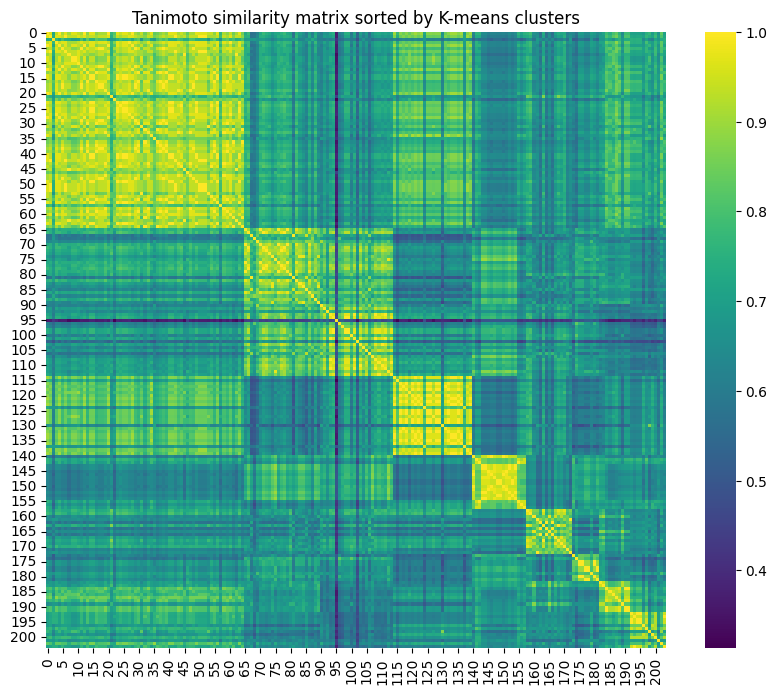

In [6]:
# --- Step 6: Plot heatmap ---
plt.figure(figsize=(10,8))
sns.heatmap(sim_sorted, cmap='viridis')
plt.title('Tanimoto similarity matrix sorted by K-means clusters')
plt.show()

In [7]:
import numpy as np

unique_clusters = np.unique(clusters)
for c in unique_clusters:
    indices = np.where(clusters==c)[0]
    # within-cluster similarity
    sims = sim_matrix[np.ix_(indices, indices)]
    avg_within = (np.sum(sims) - len(indices)) / (len(indices)*(len(indices)-1))
    print(f"Cluster {c}: Avg within-cluster Tanimoto = {avg_within:.3f}")


Cluster 0: Avg within-cluster Tanimoto = 0.908
Cluster 1: Avg within-cluster Tanimoto = 0.857
Cluster 2: Avg within-cluster Tanimoto = 0.821
Cluster 3: Avg within-cluster Tanimoto = 0.910
Cluster 4: Avg within-cluster Tanimoto = 0.904
Cluster 5: Avg within-cluster Tanimoto = 0.854
Cluster 6: Avg within-cluster Tanimoto = 0.862
Cluster 7: Avg within-cluster Tanimoto = 0.884
Cluster 8: Avg within-cluster Tanimoto = 0.829


for the scaffold, i.e. the most representative molecules


In [10]:
for c in unique_clusters:
    # Find indices of compounds in cluster c
    indices = np.where(clusters == c)[0]

    # Similarity matrix subset for the cluster
    sims = sim_matrix[np.ix_(indices, indices)]

    # Compute average similarity per compound
    avg_sims = np.mean(sims, axis=1);

    # Representative index = compound with highest average similarity
    rep_idx = indices[np.argmax(avg_sims)];

    # Get SMILES and name
    rep_smiles = smiles_list[rep_idx];
    orig_df_idx = valid_indices[rep_idx]; # Map back to original df index
    rep_name = df['common'].iloc[orig_df_idx]; # Use original df and mapped index

    print(f"Cluster {c} representative:");
    print(f"  Name:   {rep_name}");
    print(f"  SMILES: {rep_smiles}");

Cluster 0 representative:
  Name:   Rhamnazin
  SMILES: COc1cc(O)c2C(=O)C(=C(Oc2c1)c3ccc(O)c(OC)c3)O
Cluster 1 representative:
  Name:   Gancaonin G
  SMILES: COc1cc2OC=C(C(=O)c2c(O)c1CC=C(C)C)c3ccc(O)cc3
Cluster 2 representative:
  Name:   Yinyanghuo D
  SMILES: CC(C)=CCc1cc(ccc1O)C2=CC(=O)c3c(O)cc(O)cc3O2
Cluster 3 representative:
  Name:   quercetin
  SMILES: Oc1cc(O)c2C(=O)C(=C(Oc2c1)c3ccc(O)c(O)c3)O
Cluster 4 representative:
  Name:   9-O-Methylcoumestrol
  SMILES: CC1C(C(C(C(O1)OC2=C(OC3=C(C(=CC(=C3C2=O)O)O)CC=C(C)C)C4=CC=C(C=C4)OC)OC5C(C(C(C(O5)CO)O)O)O)O)O
Cluster 5 representative:
  Name:   glyasperin F
  SMILES: CC1(C)Oc2c(ccc(O)c2C=C1)C3COc4cc(O)cc(O)c4C3=O
Cluster 6 representative:
  Name:   4',5',7-trimethyl-3-methoxyflavone
  SMILES: CC(C)(CCC1=C2C(=C(C=C1O)O)C(=O)C(=C(O2)C3=CC=C(C=C3)OC)O)OC
Cluster 7 representative:
  Name:   5,8-Dihydroxy-6,7-dimethoxyflavone
  SMILES: COC1=C(C(=C(C=C1)C2CC3=C(C(=C(C=C3)O)OC)OC2)O)OC
Cluster 8 representative:
  Name:   (3R)-7,2',3'-tri

Valid molecules: 204

Representative molecules per cluster:

Cluster 0
  Name   : Rhamnazin
  SMILES : COc1cc(O)c2C(=O)C(=C(Oc2c1)c3ccc(O)c(OC)c3)O

Cluster 1
  Name   : Gancaonin G
  SMILES : COc1cc2OC=C(C(=O)c2c(O)c1CC=C(C)C)c3ccc(O)cc3

Cluster 2
  Name   : Yinyanghuo D
  SMILES : CC(C)=CCc1cc(ccc1O)C2=CC(=O)c3c(O)cc(O)cc3O2

Cluster 3
  Name   : quercetin
  SMILES : Oc1cc(O)c2C(=O)C(=C(Oc2c1)c3ccc(O)c(O)c3)O

Cluster 4
  Name   : 9-O-Methylcoumestrol
  SMILES : CC1C(C(C(C(O1)OC2=C(OC3=C(C(=CC(=C3C2=O)O)O)CC=C(C)C)C4=CC=C(C=C4)OC)OC5C(C(C(C(O5)CO)O)O)O)O)O

Cluster 5
  Name   : glyasperin F
  SMILES : CC1(C)Oc2c(ccc(O)c2C=C1)C3COc4cc(O)cc(O)c4C3=O

Cluster 6
  Name   : 4',5',7-trimethyl-3-methoxyflavone
  SMILES : CC(C)(CCC1=C2C(=C(C=C1O)O)C(=O)C(=C(O2)C3=CC=C(C=C3)OC)O)OC

Cluster 7
  Name   : 5,8-Dihydroxy-6,7-dimethoxyflavone
  SMILES : COC1=C(C(=C(C=C1)C2CC3=C(C(=C(C=C3)O)OC)OC2)O)OC

Cluster 8
  Name   : (3R)-7,2',3'-trihydroxy-4-methoxyisoflavan
  SMILES : COC1=CC(=CC(=C1OC)OC

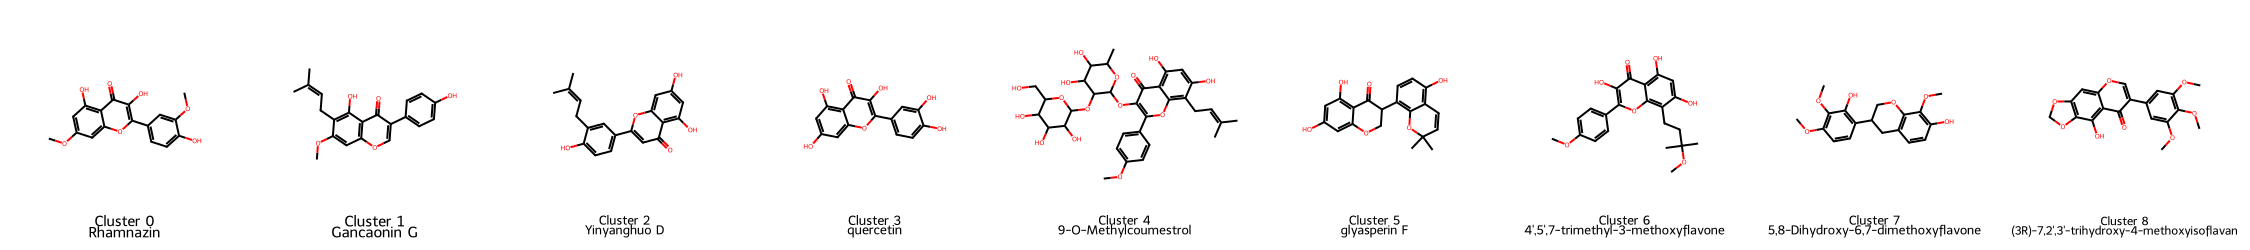

Cluster assignment file saved: cluster_assignments_with_names.xlsx


In [14]:
# ==========================================
# Flavonoid Clustering with Names + Structures
# ==========================================

import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, Draw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --------------------------
# Step 1: Load data
# --------------------------
# Excel must contain columns: Name, SMILES
df = pd.read_excel('/content/flavonoid_smile.xlsx')  # adjust path

names_list = df['common'].tolist()
smiles_list = df['SMILES'].tolist()

# --------------------------
# Step 2: Generate MACCS fingerprints
# --------------------------
fps = []
valid_indices = []

for i, smi in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        fps.append(MACCSkeys.GenMACCSKeys(mol))
        valid_indices.append(i)

print(f"Valid molecules: {len(fps)}")

# --------------------------
# Step 3: Convert fingerprints to NumPy array
# --------------------------
fps_array = np.zeros((len(fps), fps[0].GetNumBits()), dtype=int)

for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, fps_array[i])

# --------------------------
# Step 4: K-means clustering
# --------------------------
best_k = 9  # replace with silhouette-optimal value

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(fps_array)

# --------------------------
# Step 5: Tanimoto similarity matrix
# --------------------------
n = len(fps)
sim_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

# --------------------------
# Step 6: Identify representative molecules
# --------------------------
representatives = []
unique_clusters = np.unique(clusters)

print("\nRepresentative molecules per cluster:\n")

for c in unique_clusters:
    indices = np.where(clusters == c)[0]
    sims = sim_matrix[np.ix_(indices, indices)]
    avg_sims = np.mean(sims, axis=1)

    rep_idx = indices[np.argmax(avg_sims)]
    representatives.append(rep_idx)

    orig_idx = valid_indices[rep_idx]

    print(f"Cluster {c}")
    print(f"  Name   : {df.loc[orig_idx, 'common']}")
    print(f"  SMILES : {df.loc[orig_idx, 'SMILES']}\n")

# --------------------------
# Step 7: Draw representative structures
# --------------------------
rep_mols = [
    Chem.MolFromSmiles(df.loc[valid_indices[i], 'SMILES'])
    for i in representatives
]

legends = [
    f"Cluster {c}\n{df.loc[valid_indices[i], 'common']}"
    for c, i in zip(unique_clusters, representatives)
]

img = Draw.MolsToGridImage(
    rep_mols,
    molsPerRow=best_k,
    subImgSize=(250, 250),
    legends=legends
)

display(img)

# --------------------------
# Step 8: Save cluster assignment file
# --------------------------
df_cluster_output = df.iloc[valid_indices].copy()
df_cluster_output['Cluster'] = clusters

df_cluster_output.to_excel(
    "cluster_assignments_with_names.xlsx",
    index=False
)

print("Cluster assignment file saved: cluster_assignments_with_names.xlsx")


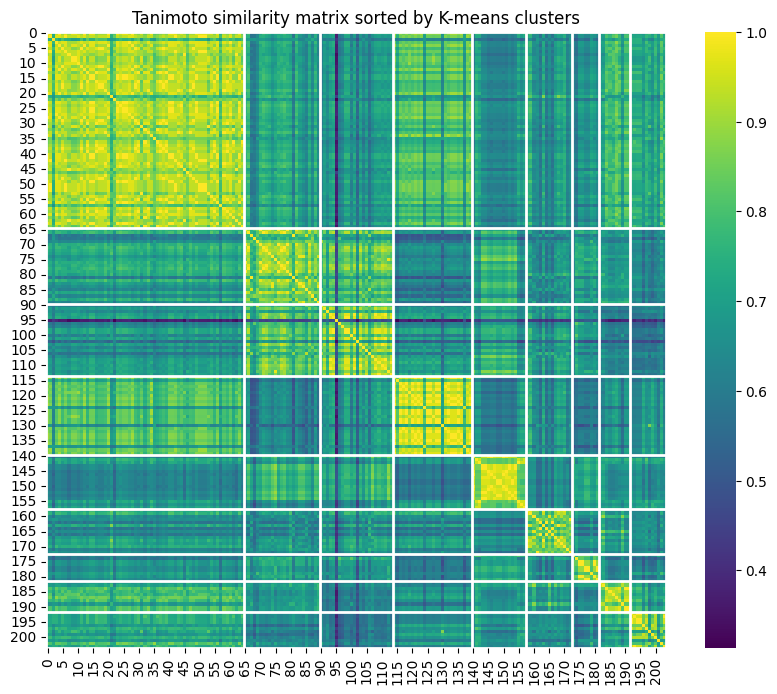

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(sim_sorted, cmap='viridis')
# Draw lines to separate clusters
cum_sizes = [0] + [np.sum(clusters==c) for c in unique_clusters]
for s in np.cumsum(cum_sizes):
    plt.axhline(s, color='white', lw=2)
    plt.axvline(s, color='white', lw=2)
plt.title('Tanimoto similarity matrix sorted by K-means clusters')
plt.show()


one whole script

Valid molecules: 204


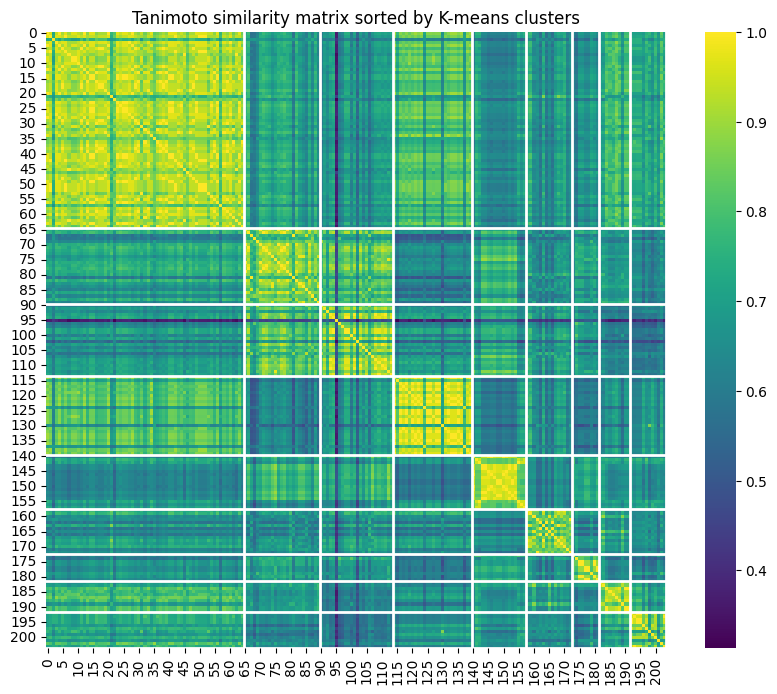

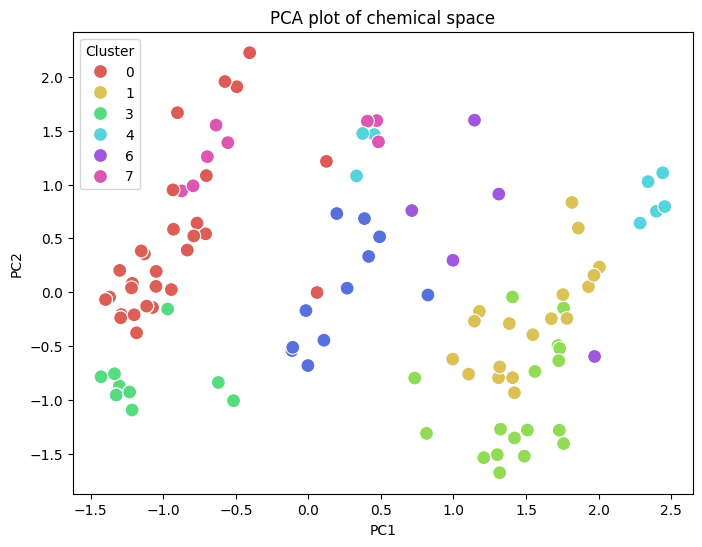

Cluster 0 representative SMILES: COc1cc(O)c2C(=O)C(=C(Oc2c1)c3ccc(O)c(OC)c3)O
Cluster 1 representative SMILES: COc1cc2OC=C(C(=O)c2c(O)c1CC=C(C)C)c3ccc(O)cc3
Cluster 2 representative SMILES: CC(C)=CCc1cc(ccc1O)C2=CC(=O)c3c(O)cc(O)cc3O2
Cluster 3 representative SMILES: Oc1cc(O)c2C(=O)C(=C(Oc2c1)c3ccc(O)c(O)c3)O
Cluster 4 representative SMILES: CC1C(C(C(C(O1)OC2=C(OC3=C(C(=CC(=C3C2=O)O)O)CC=C(C)C)C4=CC=C(C=C4)OC)OC5C(C(C(C(O5)CO)O)O)O)O)O
Cluster 5 representative SMILES: CC1(C)Oc2c(ccc(O)c2C=C1)C3COc4cc(O)cc(O)c4C3=O
Cluster 6 representative SMILES: CC(C)(CCC1=C2C(=C(C=C1O)O)C(=O)C(=C(O2)C3=CC=C(C=C3)OC)O)OC
Cluster 7 representative SMILES: COC1=C(C(=C(C=C1)C2CC3=C(C(=C(C=C3)O)OC)OC2)O)OC
Cluster 8 representative SMILES: COC1=CC(=CC(=C1OC)OC)C2=COC3=CC4=C(C(=C3C2=O)O)OCO4


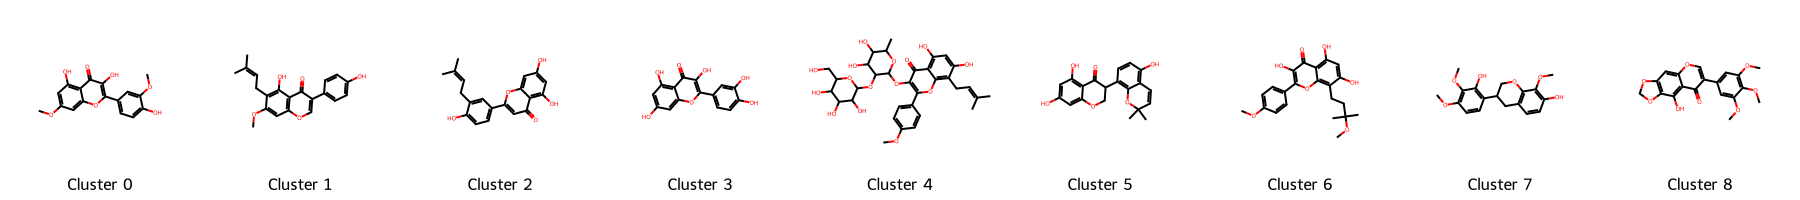

In [16]:
# ==========================
# Flavonoid Clustering & Visualization Workflow
# ==========================

import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, Draw
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Step 1: Load SMILES
# --------------------------
df = pd.read_excel('/content/flavonoid_smile.xlsx')  # Adjust your path
smiles_list = df['SMILES'].tolist()        # Ensure column name is 'SMILES'

# --------------------------
# Step 2: Generate MACCS fingerprints
# --------------------------
fps = []
valid_indices = []
for i, smi in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        fps.append(MACCSkeys.GenMACCSKeys(mol))
        valid_indices.append(i)

n = len(fps)
print(f"Valid molecules: {n}")

# --------------------------
# Step 3: Convert fingerprints to numpy array for K-means
# --------------------------
fps_array = np.zeros((n, fps[0].GetNumBits()), dtype=int)
for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, fps_array[i])

# --------------------------
# Step 4: Determine best k (from silhouette)
# --------------------------
best_k = 9  # Replace with your silhouette-optimal k

# --------------------------
# Step 5: Run K-means clustering
# --------------------------
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(fps_array)

# --------------------------
# Step 6: Compute Tanimoto similarity matrix
# --------------------------
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sim_matrix[i,j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

# --------------------------
# Step 7: Sort matrix by cluster
# --------------------------
sorted_indices = np.argsort(clusters)
sim_sorted = sim_matrix[np.ix_(sorted_indices, sorted_indices)]

# --------------------------
# Step 8: Plot Tanimoto heatmap
# --------------------------
plt.figure(figsize=(10,8))
sns.heatmap(sim_sorted, cmap='viridis')
# Draw lines to separate clusters
cum_sizes = np.cumsum([np.sum(clusters==c) for c in range(best_k)])
for s in cum_sizes:
    plt.axhline(s, color='white', lw=2)
    plt.axvline(s, color='white', lw=2)
plt.title('Tanimoto similarity matrix sorted by K-means clusters')
plt.show()

# --------------------------
# Step 9: PCA 2D scatter colored by cluster
# --------------------------
pca = PCA(n_components=2)
coords = pca.fit_transform(fps_array)

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=clusters, palette='hls', s=100)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA plot of chemical space")
plt.legend(title="Cluster")
plt.show()

# --------------------------
# Step 10: Identify representative molecules per cluster
# --------------------------
representatives = []
unique_clusters = np.unique(clusters)

for c in unique_clusters:
    indices = np.where(clusters == c)[0]
    sims = sim_matrix[np.ix_(indices, indices)]
    avg_sims = np.mean(sims, axis=1)
    rep_idx = indices[np.argmax(avg_sims)]
    representatives.append(rep_idx)
    print(f"Cluster {c} representative SMILES: {smiles_list[rep_idx]}")

# --------------------------
# Step 11: Draw representative molecules
# --------------------------
rep_mols = [Chem.MolFromSmiles(smiles_list[i]) for i in representatives]
img = Draw.MolsToGridImage(rep_mols, molsPerRow=best_k, subImgSize=(200,200),
                           legends=[f"Cluster {c}" for c in unique_clusters])
display(img)

# --------------------------
# Step 12: Save cluster info and statistics
# --------------------------
df_clusters = pd.DataFrame({'SMILES': smiles_list, 'Cluster': clusters})
df_clusters.to_excel("cluster_assignments.xlsx", index=False)

# Cluster-level average within-cluster Tanimoto
avg_within = []
for c in unique_clusters:
    indices = np.where(clusters==c)[0]
    sims = sim_matrix[np.ix_(indices, indices)]
    avg = (np.sum(sims) - len(indices)) / (len(indices)*(len(indices)-1))  # exclude diagonal
    avg_within.append((c, avg))

avg_df = pd.DataFrame(avg_within, columns=['Cluster','Avg_Tanimoto_within'])
avg_df.to_excel("cluster_similarity_summary1.xlsx", index=False)


In [18]:
cluster_scores = []

for idx in range(n):
    c = clusters[idx]
    same_cluster = np.where(clusters == c)[0]

    sims = sim_matrix[idx, same_cluster]

    # exclude self-similarity
    score = (np.sum(sims) - 1) / (len(same_cluster) - 1)
    cluster_scores.append(score)


In [21]:
df_output = pd.DataFrame({
    'Chemical_Name': df.iloc[valid_indices]['common'].values,
    'SMILES': df.iloc[valid_indices]['SMILES'].values,
    'Cluster': clusters,
    'Avg_Tanimoto_in_cluster': cluster_scores
})

df_output.to_excel("cluster_detailed_output.xlsx", index=False)


In [ ]:
import pandas as pd

# Create a label list for sorted molecules
cluster_labels_sorted = clusters[sorted_indices]

# Example: print first 10 to see which cluster
print(cluster_labels_sorted[:10])


[0 0 0 0 0 0 0 0 0 0]


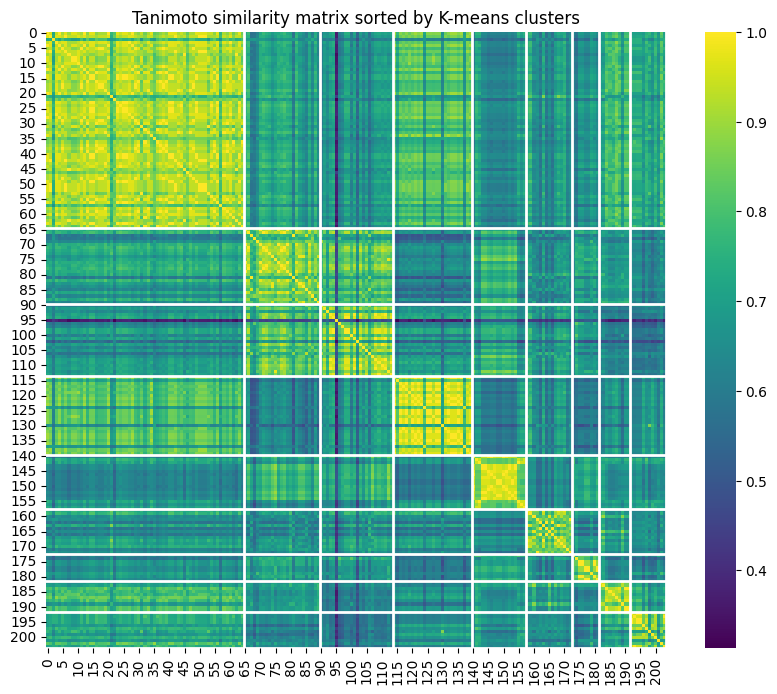

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(sim_sorted, cmap='viridis')

# Draw cluster boundaries if you want
for s in cum_sizes:
    plt.axhline(s, color='white', lw=2)
    plt.axvline(s, color='white', lw=2)

plt.title('Tanimoto similarity matrix sorted by K-means clusters')

# Save figure to file
plt.savefig("tanimoto_heatmap.png", dpi=300, bbox_inches='tight')  # dpi=300 for high quality
plt.show()


summemry of hte cluster

In [23]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

unique_clusters = np.unique(clusters)

for c in unique_clusters:
    indices = np.where(clusters==c)[0]
    print(f"\nCluster {c} summary:")

    # 1. Number of molecules
    print(f"Number of molecules: {len(indices)}")

    # 2. Representative molecule
    sims = sim_matrix[np.ix_(indices, indices)]
    avg_sims = np.mean(sims, axis=1)
    rep_idx = indices[np.argmax(avg_sims)]
    print(f"Representative SMILES: {smiles_list[rep_idx]}")

    # 3. Average molecular weight and LogP
    mols = [Chem.MolFromSmiles(smiles_list[i]) for i in indices]
    mw = [Descriptors.MolWt(m) for m in mols]
    logp = [Descriptors.MolLogP(m) for m in mols]
    print(f"Avg MolWt: {np.mean(mw):.2f}, Avg LogP: {np.mean(logp):.2f}")

    # 4. Draw representative molecule
    Draw.MolToImage(mols[np.argmax(avg_sims)])



Cluster 0 summary:
Number of molecules: 65
Representative SMILES: COc1cc(O)c2C(=O)C(=C(Oc2c1)c3ccc(O)c(OC)c3)O
Avg MolWt: 325.66, Avg LogP: 2.92

Cluster 1 summary:
Number of molecules: 25
Representative SMILES: COc1cc2OC=C(C(=O)c2c(O)c1CC=C(C)C)c3ccc(O)cc3
Avg MolWt: 372.81, Avg LogP: 4.41

Cluster 2 summary:
Number of molecules: 24
Representative SMILES: CC(C)=CCc1cc(ccc1O)C2=CC(=O)c3c(O)cc(O)cc3O2
Avg MolWt: 360.64, Avg LogP: 4.21

Cluster 3 summary:
Number of molecules: 26
Representative SMILES: Oc1cc(O)c2C(=O)C(=C(Oc2c1)c3ccc(O)c(O)c3)O
Avg MolWt: 291.26, Avg LogP: 2.13

Cluster 4 summary:
Number of molecules: 18
Representative SMILES: CC1C(C(C(C(O1)OC2=C(OC3=C(C(=CC(=C3C2=O)O)O)CC=C(C)C)C4=CC=C(C=C4)OC)OC5C(C(C(C(O5)CO)O)O)O)O)O
Avg MolWt: 674.42, Avg LogP: -0.79

Cluster 5 summary:
Number of molecules: 15
Representative SMILES: CC1(C)Oc2c(ccc(O)c2C=C1)C3COc4cc(O)cc(O)c4C3=O
Avg MolWt: 331.82, Avg LogP: 4.04

Cluster 6 summary:
Number of molecules: 9
Representative SMILES: CC(C)

saving file in words


In [ ]:
!pip install python-docx


In [28]:
# =====================================================
# Flavonoid clustering report with structures (Word)
# 3 molecules per row for comparison
# =====================================================

!pip install python-docx # Ensure docx is installed

import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, Draw
from sklearn.cluster import KMeans
from docx import Document
from docx.shared import Inches
import os

# --------------------------
# Step 1: Load Excel file
# --------------------------
input_file = "/content/flavonoid_smile.xlsx"   # adjust path
df = pd.read_excel(input_file)

names = df["common"].tolist()
smiles = df["SMILES"].tolist()

# --------------------------
# Step 2: Generate MACCS fingerprints
# --------------------------
fps = []
valid_indices = []

for i, smi in enumerate(smiles):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fps.append(MACCSkeys.GenMACCSKeys(mol))
        valid_indices.append(i)

print(f"Valid molecules: {len(fps)}")

# --------------------------
# Step 3: Fingerprint array
# --------------------------
fps_array = np.zeros((len(fps), fps[0].GetNumBits()), dtype=int)
for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, fps_array[i])

# --------------------------
# Step 4: K-means clustering
# --------------------------
best_k = 9
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(fps_array)

# --------------------------
# Step 5: Tanimoto similarity matrix
# --------------------------
n = len(fps)
sim_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

# --------------------------
# Step 6: Avg within-cluster Tanimoto score
# --------------------------
cluster_scores = []

for i in range(n):
    same_cluster = np.where(clusters == clusters[i])[0]
    sims = sim_matrix[i, same_cluster]
    score = (np.sum(sims) - 1) / (len(same_cluster) - 1)
    cluster_scores.append(score)

# --------------------------
# Step 7: Create Word document
# --------------------------
doc = Document()
doc.add_heading("Flavonoid Clustering Report – flavonid Cluster \nThe file contains the k clustering 10 i.e it also applies k clustering within the data  ", level=1)

img_dir = "mol_images"
os.makedirs(img_dir, exist_ok=True)

# --------------------------
# Step 8: Add molecules (3 per row)
# --------------------------
table = doc.add_table(rows=0, cols=3)

for i, orig_idx in enumerate(valid_indices):

    # create new row every 3 molecules
    if i % 3 == 0:
        row_cells = table.add_row().cells

    mol = Chem.MolFromSmiles(df.loc[orig_idx, "SMILES"])
    img_path = f"{img_dir}/mol_{i}.png"
    Draw.MolToFile(mol, img_path, size=(250, 250))

    cell = row_cells[i % 3]

    cell.paragraphs[0].add_run(
        f"{df.loc[orig_idx, 'common']}\n"
        f"Cluster: {clusters[i]}\n"
        f"Avg Tanimoto: {cluster_scores[i]:.3f}\n"
    ).bold = True

    cell.add_paragraph(f"SMILES:\n{df.loc[orig_idx, 'SMILES']}")

    cell.add_paragraph().add_run().add_picture(
        img_path, width=Inches(1.5)
    )

# --------------------------
# Step 9: Save Word file
# --------------------------
output_file = "report of flavonoid cluster.docx"
doc.save(output_file)

print(f"Word report saved as: {output_file}")

Valid molecules: 204
Word report saved as: report of flavonoid cluster.docx


for each clustering


In [37]:
# =====================================================
# Flavonoid clustering reports per cluster (Word)
# =====================================================

!pip install python-docx scikit-learn

import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, Draw
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from docx import Document
from docx.shared import Inches
import os

# --------------------------
# Step 1: Load Excel file
# --------------------------
input_file = "/content/flavonoid_smile.xlsx"  # adjust path
df = pd.read_excel(input_file)

names = df["common"].tolist()
smiles = df["SMILES"].tolist()

# --------------------------
# Step 2: Generate MACCS fingerprints
# --------------------------
fps = []
valid_indices = []

for i, smi in enumerate(smiles):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fps.append(MACCSkeys.GenMACCSKeys(mol))
        valid_indices.append(i)

print(f"Valid molecules: {len(fps)}")

# --------------------------
# Step 3: Fingerprint array
# --------------------------
fps_array = np.zeros((len(fps), fps[0].GetNumBits()), dtype=int)
for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, fps_array[i])

# --------------------------
# Step 4: Main K-means clustering
# --------------------------
best_k = 9
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(fps_array)

# --------------------------
# Step 5: Tanimoto similarity matrix
# --------------------------
n = len(fps)
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

# --------------------------
# Step 6: Avg within-cluster Tanimoto score
# --------------------------
cluster_scores = []
for i in range(n):
    same_cluster = np.where(clusters == clusters[i])[0]
    sims = sim_matrix[i, same_cluster]
    score = (np.sum(sims) - 1) / (len(same_cluster) - 1)
    cluster_scores.append(score)

# --------------------------
# Step 7: Create folder for images
# --------------------------
img_dir = "mol_images_per_cluster"
os.makedirs(img_dir, exist_ok=True)

# --------------------------
# Step 8: Loop over main clusters
# --------------------------
for c in range(best_k):
    cluster_indices = [valid_indices[i] for i in range(len(valid_indices)) if clusters[i] == c]

    if not cluster_indices:
        continue

    # Extract fingerprints for this cluster
    cluster_fps = fps_array[[i for i in range(len(fps)) if i in cluster_indices]]

    # --------------------------
    # Step 8a: Determine optimal sub-cluster number using silhouette
    # --------------------------
    max_sub_k = min(5, len(cluster_indices))  # limit to <=5
    best_sil_score = -1
    best_sub_k = 1
    sub_labels = np.zeros(len(cluster_indices), dtype=int)

    if len(cluster_indices) >= 3:  # silhouette requires >=2 clusters
        for k_sub in range(2, max_sub_k + 1):
            kmeans_sub = KMeans(n_clusters=k_sub, random_state=42, n_init=5)
            labels = kmeans_sub.fit_predict(cluster_fps)
            try:
                score = silhouette_score(cluster_fps, labels)
            except:
                score = -1
            if score > best_sil_score:
                best_sil_score = score
                best_sub_k = k_sub
                sub_labels = labels
    else:
        sub_labels = np.zeros(len(cluster_indices), dtype=int)
        best_sub_k = 1

    # --------------------------
    # Step 8b: Create Word document per cluster
    # --------------------------
    doc = Document()
    doc.add_heading(f"Flavonoid Cluster {c} Report", level=1)
    doc.add_paragraph(f"Total molecules in cluster: {len(cluster_indices)}")
    doc.add_paragraph(f"Optimal sub-clusters: {best_sub_k}")

    table = doc.add_table(rows=0, cols=3)

    for idx, orig_idx in enumerate(cluster_indices):
        # new row every 3 molecules
        if idx % 3 == 0:
            row_cells = table.add_row().cells

        mol = Chem.MolFromSmiles(df.loc[orig_idx, "SMILES"])
        img_path = f"{img_dir}/mol_cluster_{c}_idx_{idx}.png"
        Draw.MolToFile(mol, img_path, size=(250, 250))

        cell = row_cells[idx % 3]

        # Add molecule name, cluster, sub-cluster, and average Tanimoto score
        cell.paragraphs[0].add_run(
            f"{df.loc[orig_idx, 'common']}\n"
            f"Cluster: {c} (Sub-cluster: {sub_labels[idx]})\n"
            f"Avg Tanimoto: {cluster_scores[valid_indices.index(orig_idx)]:.3f}\n"
        ).bold = True

        # Add SMILES
        cell.add_paragraph(f"SMILES:\n{df.loc[orig_idx, 'SMILES']}")

        # Add image
        cell.add_paragraph().add_run().add_picture(
            img_path, width=Inches(1.5)
        )

    # Save the document for the current cluster
    output_file = f"flavonoid_cluster_{c}_report.docx"
    doc.save(output_file)
    print(f"Report for Cluster {c} saved as: {output_file}")

print("All cluster reports generated.")

Valid molecules: 204
Report for Cluster 0 saved as: flavonoid_cluster_0_report.docx
Report for Cluster 1 saved as: flavonoid_cluster_1_report.docx
Report for Cluster 2 saved as: flavonoid_cluster_2_report.docx
Report for Cluster 3 saved as: flavonoid_cluster_3_report.docx
Report for Cluster 4 saved as: flavonoid_cluster_4_report.docx
Report for Cluster 5 saved as: flavonoid_cluster_5_report.docx
Report for Cluster 6 saved as: flavonoid_cluster_6_report.docx
Report for Cluster 7 saved as: flavonoid_cluster_7_report.docx
Report for Cluster 8 saved as: flavonoid_cluster_8_report.docx
All cluster reports generated.


for the graph

In [40]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Make sure 'subcluster_plots' directory exists, just in case
# (It should have been created by IMJPfNAQue8X)
os.makedirs("subcluster_plots", exist_ok=True)
print(f"Ensuring directory 'subcluster_plots' exists at {os.getcwd()}/subcluster_plots")

with PdfPages('clustering_summary.pdf') as pdf:
    # overall plot
    fig, ax = plt.subplots(figsize=(10,8))
    sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=clusters, palette="tab10", s=60, ax=ax)
    ax.set_title(f"Overall K-means clustering (k={best_k})")
    pdf.savefig(fig)
    plt.close(fig)
    print("Overall plot added to PDF.")

    # sub-cluster plots
    for c in range(best_k):
        img_path = f"subcluster_plots/cluster_{c}_subcluster.png"
        if os.path.exists(img_path):
            print(f"Found image file for Cluster {c}: {img_path}")
            try:
                img = plt.imread(img_path)
                fig, ax = plt.subplots(figsize=(8,6))
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"Cluster {c} Sub-clustering")
                pdf.savefig(fig)
                plt.close(fig)
                print(f"Sub-cluster plot for Cluster {c} added to PDF.")
            except Exception as e:
                print(f"ERROR: Could not add sub-cluster plot for Cluster {c} from {img_path}. Reason: {e}")
        else:
            print(f"WARNING: Image file not found for Cluster {c}: {img_path}. Skipping.")

print("PDF 'clustering_summary.pdf' generation complete.")

Ensuring directory 'subcluster_plots' exists at /content/subcluster_plots
Overall plot added to PDF.
Found image file for Cluster 0: subcluster_plots/cluster_0_subcluster.png
Sub-cluster plot for Cluster 0 added to PDF.
Found image file for Cluster 1: subcluster_plots/cluster_1_subcluster.png
Sub-cluster plot for Cluster 1 added to PDF.
Found image file for Cluster 2: subcluster_plots/cluster_2_subcluster.png
Sub-cluster plot for Cluster 2 added to PDF.
Found image file for Cluster 3: subcluster_plots/cluster_3_subcluster.png
Sub-cluster plot for Cluster 3 added to PDF.
Found image file for Cluster 4: subcluster_plots/cluster_4_subcluster.png
Sub-cluster plot for Cluster 4 added to PDF.
Found image file for Cluster 5: subcluster_plots/cluster_5_subcluster.png
Sub-cluster plot for Cluster 5 added to PDF.
Found image file for Cluster 6: subcluster_plots/cluster_6_subcluster.png
Sub-cluster plot for Cluster 6 added to PDF.
Found image file for Cluster 7: subcluster_plots/cluster_7_subclus

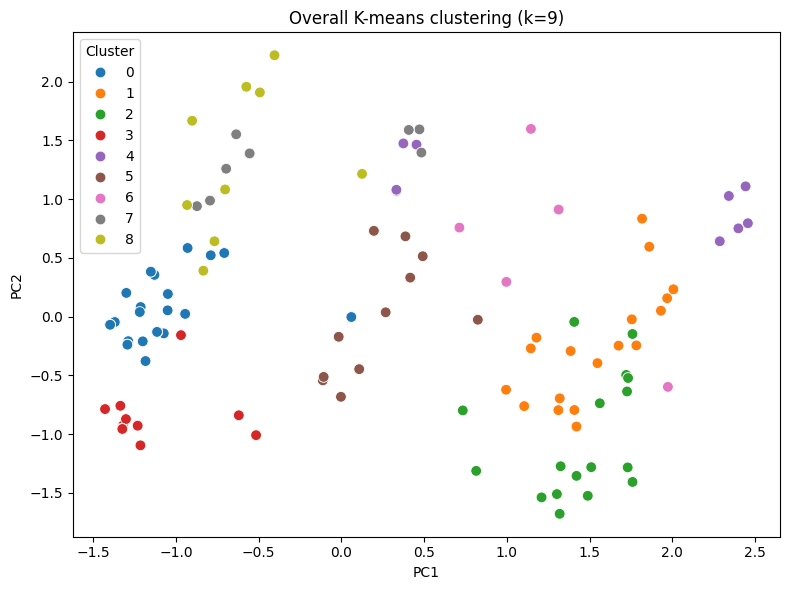

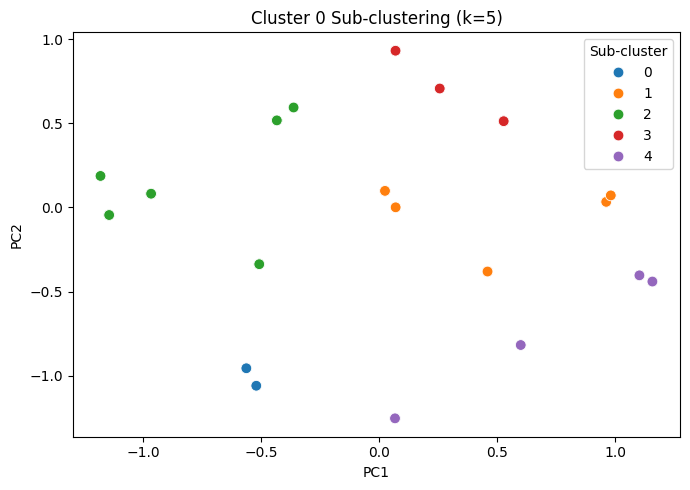

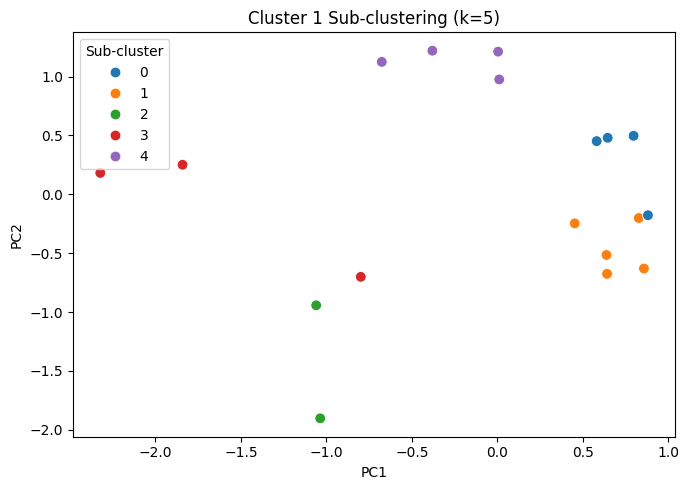

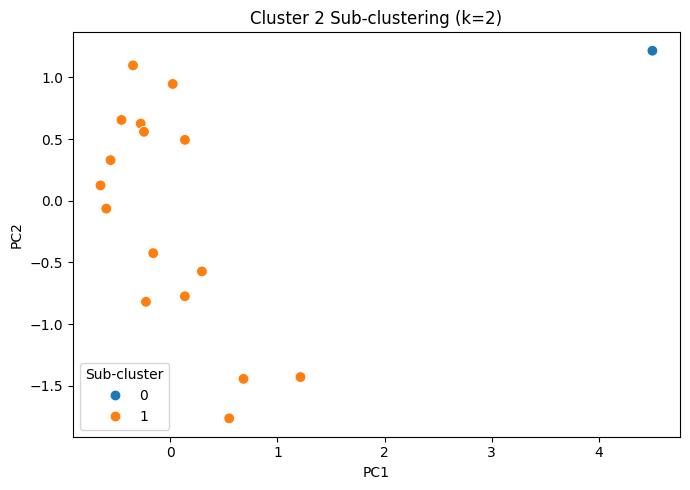

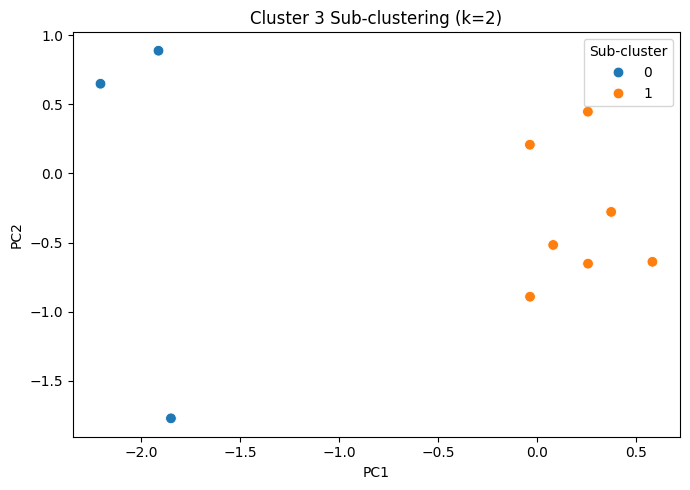

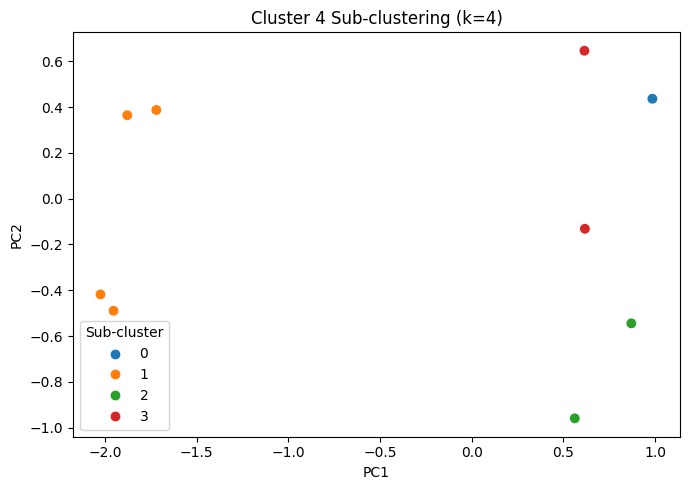

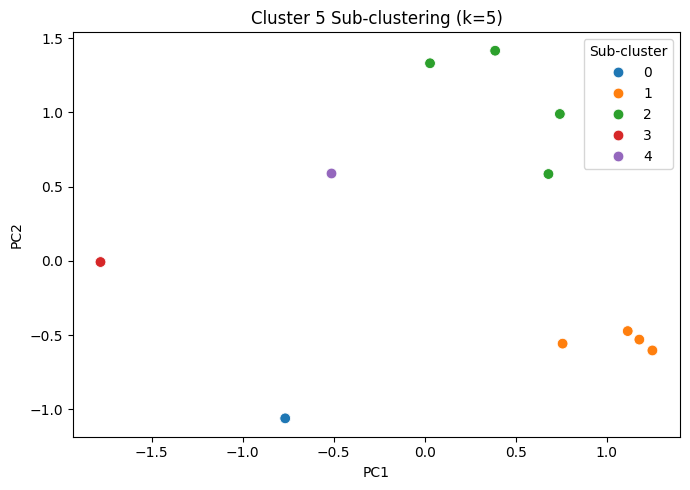

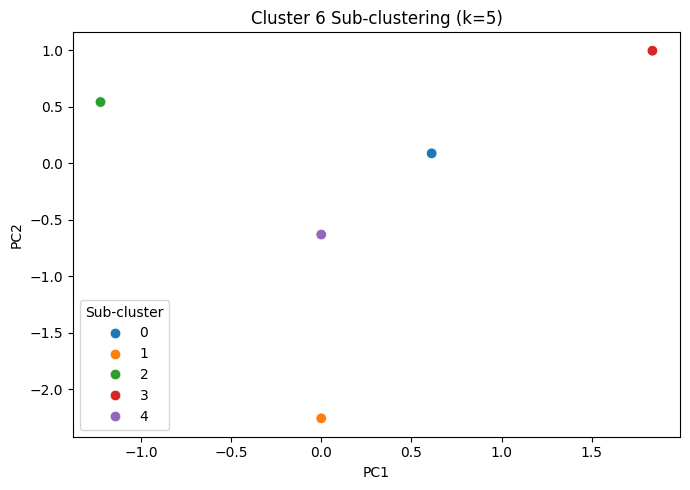

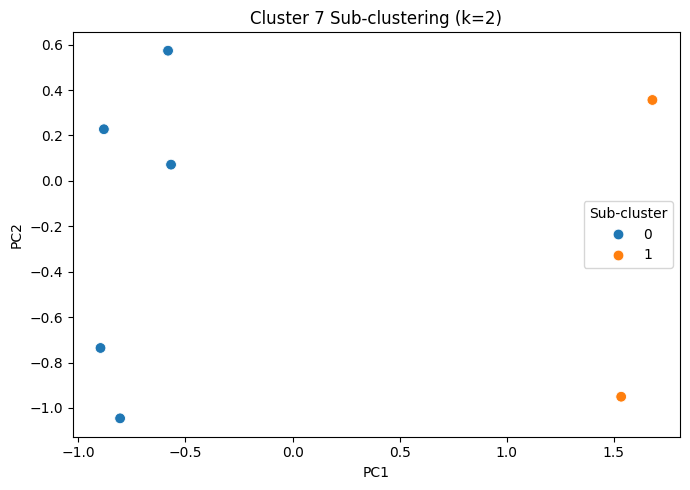

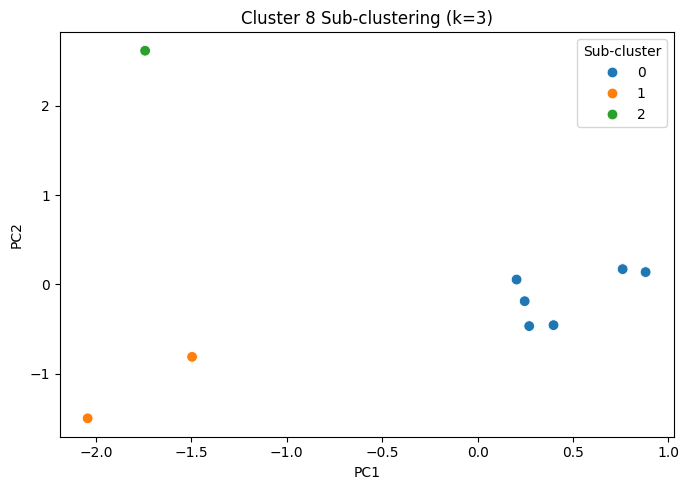

Overall clustering and sub-cluster plots saved.


In [38]:
# =====================================================
# Flavonoid clustering visualization (overall + sub-clusters)
# =====================================================

!pip install matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --------------------------
# Step 1: Load data and fingerprints
# --------------------------
input_file = "/content/flavonoid_smile.xlsx"  # adjust path
df = pd.read_excel(input_file)

smiles = df["SMILES"].tolist()
fps = []
valid_indices = []

for i, smi in enumerate(smiles):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fps.append(MACCSkeys.GenMACCSKeys(mol))
        valid_indices.append(i)

# Fingerprint array
fps_array = np.zeros((len(fps), fps[0].GetNumBits()), dtype=int)
for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, fps_array[i])

# --------------------------
# Step 2: Main clustering (best_k = 9)
# --------------------------
best_k = 9
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(fps_array)

# --------------------------
# Step 3: Dimensionality reduction for plotting
# --------------------------
# You can choose PCA or t-SNE
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(fps_array)

# --------------------------
# Step 4: Plot overall clustering
# --------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=clusters, palette="tab10", s=60)
plt.title(f"Overall K-means clustering (k={best_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig("overall_clustering.png", dpi=300)
plt.show()
plt.close() # Close the figure after showing and saving

# --------------------------
# Step 5: Sub-clustering within each main cluster
# --------------------------
os.makedirs("subcluster_plots", exist_ok=True)

for c in range(best_k):
    cluster_indices = [i for i in range(len(fps)) if clusters[i] == c]
    if len(cluster_indices) < 3:
        continue

    cluster_fps = fps_array[cluster_indices]

    # Determine optimal sub-cluster number using silhouette
    max_sub_k = min(5, len(cluster_indices))
    best_sil_score = -1
    best_sub_k = 1
    sub_labels = np.zeros(len(cluster_indices), dtype=int)

    for k_sub in range(2, max_sub_k + 1):
        kmeans_sub = KMeans(n_clusters=k_sub, random_state=42, n_init=5)
        labels = kmeans_sub.fit_predict(cluster_fps)
        try:
            score = silhouette_score(cluster_fps, labels)
        except:
            score = -1
        if score > best_sil_score:
            best_sil_score = score
            best_sub_k = k_sub
            sub_labels = labels

    # Dimensionality reduction for cluster
    pca_sub = PCA(n_components=2, random_state=42)
    X_sub_2d = pca_sub.fit_transform(cluster_fps)

    plt.figure(figsize=(7,5))
    sns.scatterplot(x=X_sub_2d[:,0], y=X_sub_2d[:,1], hue=sub_labels, palette="tab10", s=60)
    plt.title(f"Cluster {c} Sub-clustering (k={best_sub_k})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Sub-cluster")
    plt.tight_layout()
    plt.savefig(f"subcluster_plots/cluster_{c}_subcluster.png", dpi=300)
    plt.show()
    plt.close() # Close the figure after showing and saving

print("Overall clustering and sub-cluster plots saved.")